In [ ]:
import numpy as np
import regex as re
import pandas as pd
import gc
import logging
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import string
import nltk as nlp
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec, KeyedVectors, Phrases
#from gensim.test.utils import common_texts
#from matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns

In [ ]:
!pip install -q gradio

     |████████████████████████████████| 2.9 MB 5.2 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 212 kB 54.8 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 2.0 MB 42.6 MB/s 
     |████████████████████████████████| 1.1 MB 49.7 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 253 kB 59.3 MB/s 
     |████████████████████████████████| 271 kB 70.7 MB/s 
     |████████████████████████████████| 144 kB 57.4 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 10.9 MB 34.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 62 kB 836 kB/s 
     |████████████████████████████████| 856 kB 56.7 MB/s 
     |████████████████████████

In [ ]:
import gradio as gr

/usr/local/lib/python3.7/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
from google.colab import drive

drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
dataframe = pd.read_csv('/content/Mydrive/MyDrive/FinalYearProject/IMDB-Dataset.csv')

In [ ]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
dataframe.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
dataframe['sentiment'] = dataframe['sentiment'].replace('positive', 1)
dataframe['sentiment'] = dataframe['sentiment'].replace('negative', 0)
dataframe.head()
#in case of non-binary classes it makes more sense to use label encoder rather than replace

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Check for nulls and duplicates

In [ ]:
dataframe.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
dataframe.duplicated().sum()

418

In [ ]:
dataframe.drop_duplicates(subset='review', keep='first', inplace=True)

In [ ]:
np.shape(dataframe)

(49582, 2)

In [ ]:
dataframe.duplicated().sum()

0

In [ ]:
dataframe.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Train Test Split

In [ ]:
train, test = train_test_split(dataframe, test_size = 0.2, random_state = 156, shuffle=True)

In [ ]:
train.head()

,review,sentiment
30420,I thought that this was an absolutely charming...,1
46571,I watched this show on the basis of it being t...,1
19101,There is only one film I can think of that mig...,1
14661,"Let's see... a couple dozen Gary Larson gags, ...",0
16681,"I have seen this wonderful production, and I w...",1


In [ ]:
test.head()

,review,sentiment
10310,"Chaplin was great a silent comedian, but many ...",0
20472,This has got to be one of Australia's best pro...,1
31604,A surprising misfire from the usually reliable...,0
26404,Why do people bitch about this movie and not a...,1
30664,"Criticism of the film EVENING, based on the no...",1


In [ ]:
del dataframe

In [ ]:
X_train = train['review'].values
y_train = train['sentiment'].values
X_test = test['review'].values
y_test = test['sentiment'].values

In [ ]:
del train, test

## Removing non-word characters from the dataset

In [ ]:
def preprocess(text, pattern):
    if pattern=='[.]+':
        text = re.sub(pattern, '. ', text)
    elif pattern =="[']" or pattern == '[_]+':
        text =  re.sub(pattern, ' ', text)
    else:
        text = re.sub(pattern, '', text)
    #print(text, '\n')
    return text

In [ ]:
X_train = np.vectorize(preprocess)(X_train, '<[^>]*>') #remove markup
X_test = np.vectorize(preprocess)(X_test, '<[^>]*>') #remove markup

In [ ]:
X_train = np.vectorize(preprocess)(X_train, '[.]+') #remove ... and replace with .
X_test = np.vectorize(preprocess)(X_test, '[.]+') #remove ... and replace with .

In [ ]:
X_train = np.vectorize(preprocess)(X_train, '[0-9]+') #remove numbers and replace with none
X_test = np.vectorize(preprocess)(X_test, '[0-9]+') #remove numbers and replace with none

In [ ]:
X_train = np.vectorize(preprocess)(X_train, '[,]+') #remove numbers and replace with none
X_test = np.vectorize(preprocess)(X_test, '[,]]+') #remove numbers and replace with none

In [ ]:
X_train = np.vectorize(preprocess)(X_train, "[']") #remove ' and replace with 
X_test = np.vectorize(preprocess)(X_test, "[']") #remove ' and replace with 

In [ ]:
X_train = np.vectorize(preprocess)(X_train, "[_]+") #remove ' and replace with 
X_test = np.vectorize(preprocess)(X_test, "[_]+") #remove ' and replace with _

In [ ]:
X_train = np.vectorize(preprocess)(X_train, '[^\w\s]*') #remove everything that's not word space
X_test = np.vectorize(preprocess)(X_test, '[^\w\s]*') #remove everything that's not word space
print(X_train[0])

I thought that this was an absolutely charming movie centering around the lives of MaryKate s and Ashley s characters Sam and Emma Stanton They are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do I thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then I m sure that you ll agree with me here If you haven t seen this movie yet then I say you really missedout big time and that you should definitely take the time out to see it now This movie is a real winner Sincerely Rick Morris


In [ ]:
gc.collect()

426

In [ ]:
X_train[0]

'I thought that this was an absolutely charming movie centering around the lives of MaryKate s and Ashley s characters Sam and Emma Stanton They are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do I thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then I m sure that you ll agree with me here If you haven t seen this movie yet then I say you really missedout big time and that you should definitely take the time out to see it now This movie is a real winner Sincerely Rick Morris'

In [ ]:
X_test[0]

'Chaplin was great a silent comedian but many silent era stars fell when the public heard their voices in the first talkies  In my opinion Chaplin s voice simply did not fit his silent characters that made him rich and famous  His career never recovered when sound came to film  Contrary to most of the reviews I have read Chaplin s lifestyle and politics did not help his popularity with the average viewer who expected to be entertained by Chaplin the comedian and not spend their entertainment dollar watching Chaplin s political commentary Despite Chaplin s awards and knighthood I would take exception to his contributions to humanity  The Great Dictator was made at the same time Stalin s brutal dictatorship was having it s show trials and both Dictators signed the agreement that lead to invasion of Poland by both Dictators  WWII started in an attempt to save Poland  The Nazi s were defeated in  years but Poland disappeared as a sovereign country  This happened during the time this film w

In [ ]:
X_train = [sentence.lower() for sentence in X_train] #make it lower
print(X_train[0])
X_test = [sentence.lower() for sentence in X_test] #make it lower

i thought that this was an absolutely charming movie centering around the lives of marykate s and ashley s characters sam and emma stanton they are both trying to make both themselves and their parents happy but unfortunately it s just not that easy for them to actually do i thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then i m sure that you ll agree with me here if you haven t seen this movie yet then i say you really missedout big time and that you should definitely take the time out to see it now this movie is a real winner sincerely rick morris


In [ ]:
count = CountVectorizer()
bag = count.fit_transform(X_train)
len(count.vocabulary_) #counting unique words

130984

In [ ]:
reviews = []
reviews_ = []

In [ ]:
nlp.download('stopwords')
nlp.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
lemmatizer = WordNetLemmatizer()
nlp.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
def lemmatization(text, isTrain):
    text_ = word_tokenize(text)
    tokens = []
    for word in text_:
        if word not in stop:
            tokens.append(lemmatizer.lemmatize(word))
    if isTrain:
      reviews.append(tokens)
    else:
     reviews_.append(tokens)
    text = ' '.join(tokens)
    #print(reviews[0])
    #print(reviews_[0])
    return text

In [ ]:
lemmatizer.lemmatize("bats")

'bat'

In [ ]:
lemmatizer.lemmatize("crying")

'cry'

In [ ]:
X_train = np.vectorize(lemmatization)(X_train, True)
X_test = np.vectorize(lemmatization)(X_test, False)
print(X_train[0])

thought absolutely charming movie centering around life marykate ashley character sam emma stanton trying make parent happy unfortunately easy actually thought utterly charming sweet movie real fan marvelous young lady sure agree seen movie yet say really missedout big time definitely take time see movie real winner sincerely rick morris


In [ ]:
X_test[0]

'chaplin great silent comedian many silent era star fell public heard voice first talkie opinion chaplin voice simply fit silent character made rich famous career never recovered sound came film contrary review read chaplin lifestyle politics help popularity average viewer expected entertained chaplin comedian spend entertainment dollar watching chaplin political commentary despite chaplin award knighthood would take exception contribution humanity great dictator made time stalin brutal dictatorship show trial dictator signed agreement lead invasion poland dictator wwii started attempt save poland nazi defeated year poland disappeared sovereign country happened time film made investigation hollywood federal government chaplin included joe stalin satirein addition including italian dictator perhaps would le criticism politics politician soviet mistreatment jew dissident exceeded nazi time number judged simply film many gag topical understood younger viewer know goebbels goring mussolini

In [ ]:
reviews.pop(0)
reviews_.pop(0)
print()

In [ ]:
X_train = np.array(reviews)
X_test = np.array(reviews_)
del reviews, reviews_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

39665
9917
39665
9917


In [ ]:
print(X_train[0])

['thought', 'absolutely', 'charming', 'movie', 'centering', 'around', 'life', 'marykate', 'ashley', 'character', 'sam', 'emma', 'stanton', 'trying', 'make', 'parent', 'happy', 'unfortunately', 'easy', 'actually', 'thought', 'utterly', 'charming', 'sweet', 'movie', 'real', 'fan', 'marvelous', 'young', 'lady', 'sure', 'agree', 'seen', 'movie', 'yet', 'say', 'really', 'missedout', 'big', 'time', 'definitely', 'take', 'time', 'see', 'movie', 'real', 'winner', 'sincerely', 'rick', 'morris']


In [ ]:
print(X_test[0])

['chaplin', 'great', 'silent', 'comedian', 'many', 'silent', 'era', 'star', 'fell', 'public', 'heard', 'voice', 'first', 'talkie', 'opinion', 'chaplin', 'voice', 'simply', 'fit', 'silent', 'character', 'made', 'rich', 'famous', 'career', 'never', 'recovered', 'sound', 'came', 'film', 'contrary', 'review', 'read', 'chaplin', 'lifestyle', 'politics', 'help', 'popularity', 'average', 'viewer', 'expected', 'entertained', 'chaplin', 'comedian', 'spend', 'entertainment', 'dollar', 'watching', 'chaplin', 'political', 'commentary', 'despite', 'chaplin', 'award', 'knighthood', 'would', 'take', 'exception', 'contribution', 'humanity', 'great', 'dictator', 'made', 'time', 'stalin', 'brutal', 'dictatorship', 'show', 'trial', 'dictator', 'signed', 'agreement', 'lead', 'invasion', 'poland', 'dictator', 'wwii', 'started', 'attempt', 'save', 'poland', 'nazi', 'defeated', 'year', 'poland', 'disappeared', 'sovereign', 'country', 'happened', 'time', 'film', 'made', 'investigation', 'hollywood', 'federal'

In [ ]:
bigrams = Phrases(X_train)

In [ ]:
trigrams = Phrases(sentences=bigrams[X_train])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
print(bigrams)
print(trigrams)

Phrases<2591773 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>
Phrases<2819560 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
trigrams_model = Word2Vec(sentences = trigrams[bigrams[X_train]], size = 256, min_count=3, window=5, workers=4)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
2022-05-10 15:42:32,137 : INFO : collecting all words and their counts
2022-05-10 15:42:32,139 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-10 15:42:43,589 : INFO : PROGRESS: at sentence #10000, processed 1050148 words, keeping 75597 word types
2022-05-10 15:42:55,381 : INFO : PROGRESS: at sentence #20000, processed 2098624 words, keeping 103318 word types
2022-05-10 15:43:07,328 : INFO : PROGRESS: at sentence #30000, processed 3153433 words, keeping 124604 word types
2022-05-10 15:43:18,864 : INFO : collected 142599 word types from a corpus of 4160212 raw words and 39665 sentences
2022-05-10 15:43:18,866 : INFO : Loading a fresh vocabulary
2022-05-10 15:43:19,824 : INFO : effective_min_count=3 retains 631

In [ ]:
len(trigrams_model.wv.vocab)

63134

In [ ]:
#save the model here
trigrams_model.wv.save_word2vec_format('/content/Mydrive/MyDrive/FinalYearProject/word2vec/word_embeddings_trigram_lem.txt')


2022-05-10 15:48:23,823 : INFO : storing 63134x256 projection weights into /content/Mydrive/MyDrive/FinalYearProject/word2vec/word_embeddings_trigram_lem.txt


In [ ]:
trigrams_model = KeyedVectors.load_word2vec_format('/content/Mydrive/MyDrive/FinalYearProject/word2vec/word_embeddings_trigram_lem.txt', binary = False, unicode_errors = 'ignore')

2022-05-10 15:48:38,525 : INFO : loading projection weights from /content/Mydrive/MyDrive/FinalYearProject/word2vec/word_embeddings_trigram_lem.txt
2022-05-10 15:48:47,336 : INFO : loaded (63134, 256) matrix from /content/Mydrive/MyDrive/FinalYearProject/word2vec/word_embeddings_trigram_lem.txt


In [ ]:
trigrams_model.similarity('say', 'may')

0.27540255

In [ ]:
trigrams_model.similarity('saw','say')

0.2188295

In [ ]:
trigrams_model.similarity('happy', 'unfortunate')

0.26451

In [ ]:
trigrams_model.similarity('gangsta', 'latino')

0.6969067

In [ ]:
gc.collect()

250

## Vectorization

In [ ]:
len(trigrams_model.wv.vocab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


63134

In [ ]:
list(trigrams_model.wv.vocab.keys()).index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


<function list.index>

In [ ]:
trigrams_model.wv.vocab.keys()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


dict_keys(['movie', 'film', 'one', 'like', 'good', 'character', 'would', 'really', 'time', 'even', 'get', 'story', 'make', 'see', 'also', 'great', 'scene', 'people', 'way', 'well', 'show', 'much', 'think', 'bad', 'thing', 'could', 'know', 'made', 'life', 'first', 'watch', 'go', 'many', 'actor', 'say', 'two', 'end', 'never', 'love', 'plot', 'still', 'little', 'work', 'acting', 'find', 'look', 'part', 'seen', 'something', 'take', 'lot', 'best', 'better', 'come', 'actually', 'give', 'director', 'man', 'play', 'want', 'another', 'going', 'funny', 'real', 'woman', 'guy', 'performance', 'thought', 'however', 'though', 'fact', 'watching', 'got', 'nothing', 'seems', 'ever', 'back', 'quite', 'may', 'role', 'girl', 'always', 'point', 'original', 'interesting', 'world', 'enough', 'right', 'kind', 'least', 'u', 'horror', 'day', 'comedy', 'saw', 'script', 'feel', 'year', 'without', 'kid', 'might', 'set', 'rather', 'music', 'probably', 'idea', 'since', 'bit', 'new', 'family', 'played', 'friend', 'al

In [ ]:
trigrams_model.wv.vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(63134, 256)

In [ ]:
def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review))) 
    #for review in data:
      #print(review)
     # word_map = []
      #for word in review:
       # if vocab.get(word, None) is not None:
          
      #print(word_map)
    vectorized = list(map(encode, data))
  
    print(vectorized[2])
    #print('Vectorize sentences... (done)')
    return vectorized

In [ ]:
 def get_mean():
    review_length = []
    for review in X_train:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))
maxim = get_mean()
print(maxim)

117


In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

39665
9917
39665
9917


In [ ]:
X_train = vectorize_data(trigrams[bigrams[X_train]], vocab = trigrams_model.wv.vocab)
X_test = vectorize_data(trigrams[bigrams[X_test]], vocab = trigrams_model.wv.vocab)
#X_train_pad = pad_sequences(sequences=X_train, , maxlen = maxim, padding='post', truncating='post')
#X_test_token = token_tensor.texts_to_sequences(X_test)
#X_test_pad = pad_sequences(X_test_token, maxlen = maxim, padding='post', truncating='post')

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[2, 1, 22, 100, 4, 52, 2, 53, 10748, 7864, 15418, 6710, 68, 25367, 51, 30, 202, 779, 8736, 15418, 6710, 317, 7864, 1719, 1275, 62, 1122, 68, 22, 2304, 3305, 39131, 171, 2750, 14, 9388, 336, 24, 87, 76, 7864, 1330, 7864, 123, 2017, 1561, 1, 248, 7864, 925, 3305, 1071, 87, 2750, 1588, 208, 2398, 1366, 12348, 3609, 3305, 411, 7864, 547, 20807, 2750, 8, 49, 7864, 1561, 141, 207, 1855, 7864, 239, 122, 220, 690, 62, 296, 130, 571, 2491, 683, 30576, 135, 38, 15, 1789, 143, 34, 9057, 536]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


[1427, 8036, 37103, 28740, 479, 410, 5233, 364, 33820, 2919, 62, 5609, 9, 426, 141, 26017, 46792, 14098, 31016, 299, 66, 304, 1720, 171, 45, 12150, 12, 842, 2503, 227, 93, 176]


In [ ]:
X_train_pad = pad_sequences(sequences=X_train, maxlen=maxim, padding='post', truncating='post')
X_test_pad = pad_sequences(sequences=X_test, maxlen=maxim, padding='post', truncating='post')

In [ ]:
print(X_train_pad[0])
print(X_test_pad[1])

[   67   477   894     0 32893    28 24002     5  1449  3632 26850  2361
   453   533   259   629    54    67  1154   894   811     0    63   114
  2402  5783   133   738    47     0   125    34     7   142     8   258
    49     8    13     0 26851  7045  3528  3870     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]
[   72     2  2376    51   278   246  2690   320    27   117    20   804
  1501 49689  1872   295   158   160  1018 12805  4183    15   263     7
  1052  1501   807   103   165   299   117 41042   314   257  2709  5581
   271   238     2  1587   912  3022  1121 22524   257    70 19528  

In [ ]:
print(len(X_test_pad))
print(len(y_test))

9917
9917


##Models

###Simple RNN

In [ ]:
simple_rnn_0 = Sequential()
simple_rnn_0.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
simple_rnn_0.add(SimpleRNN(128, recurrent_dropout=0.1))
simple_rnn_0.add(Dropout(0.25))
simple_rnn_0.add(Dense(64))
simple_rnn_0.add(Dropout(0.3))
simple_rnn_0.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
simple_rnn_0.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
simple_rnn_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 117, 256)          16162304  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,219,905
Trainable params: 57,601
Non-tr

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_0.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2022-05-10 12:10:00,421 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
simple_rnn_history_0 = simple_rnn_0.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=60,
                                 callbacks=[checkpoint])

Epoch 1/60
589/589 [==============================] - ETA: 0s - loss: 0.7245 - accuracy: 0.5353
Epoch 1: val_accuracy improved from -inf to 0.49042, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_0.h5
589/589 [==============================] - 56s 92ms/step - loss: 0.7245 - accuracy: 0.5353 - val_loss: 0.6937 - val_accuracy: 0.4904
Epoch 2/60
589/589 [==============================] - ETA: 0s - loss: 0.6972 - accuracy: 0.5254
Epoch 2: val_accuracy improved from 0.49042 to 0.51613, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_0.h5
589/589 [==============================] - 54s 92ms/step - loss: 0.6972 - accuracy: 0.5254 - val_loss: 0.6865 - val_accuracy: 0.5161
Epoch 3/60
589/589 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5379
Epoch 3: val_accuracy improved from 0.51613 to 0.52419, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_0.h5
589/589 [=============================

In [ ]:
del simple_rnn_0
gc.collect()

2506

In [ ]:
simple_rnn_0 = load_model('/content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_0.h5')

#### Metrics

In [ ]:
y_pred = simple_rnn_0.predict(X_test_pad)

In [ ]:
y_pred

array([[0.70890963],
       [0.7557916 ],
       [0.22150007],
       ...,
       [0.22150007],
       [0.761979  ],
       [0.7546195 ]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
accuracy_score(y_test, y_pred)

0.7473026116769185

####Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[3667 1320]
 [1186 3744]]


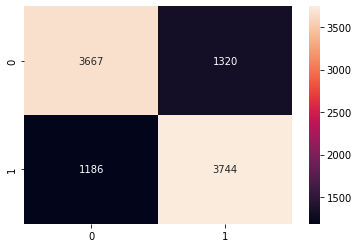

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

####Classification Report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      4987
           1       0.74      0.76      0.75      4930

    accuracy                           0.75      9917
   macro avg       0.75      0.75      0.75      9917
weighted avg       0.75      0.75      0.75      9917



###Two Layered RNN

In [ ]:
simple_rnn_1 = Sequential()
simple_rnn_1.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
simple_rnn_1.add(SimpleRNN(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
simple_rnn_1.add(SimpleRNN(128, recurrent_dropout=0.1))
simple_rnn_1.add(Dropout(0.25))
simple_rnn_1.add(Dense(64))
simple_rnn_1.add(Dropout(0.3))
simple_rnn_1.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
simple_rnn_1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
simple_rnn_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 117, 256)          16162304  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 117, 128)          49280     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_1_s.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2022-05-10 13:05:41,820 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
simple_rnn_history_1 = simple_rnn_1.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=50,
                                 callbacks=[checkpoint])

Epoch 1/60
589/589 [==============================] - ETA: 0s - loss: 0.7333 - accuracy: 0.5259
Epoch 1: val_accuracy improved from -inf to 0.50504, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_1.h5
589/589 [==============================] - 124s 198ms/step - loss: 0.7333 - accuracy: 0.5259 - val_loss: 0.7072 - val_accuracy: 0.5050
Epoch 2/60
589/589 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.5369
Epoch 2: val_accuracy did not improve from 0.50504
589/589 [==============================] - 115s 196ms/step - loss: 0.6904 - accuracy: 0.5369 - val_loss: 0.6916 - val_accuracy: 0.4975
Epoch 3/60
589/589 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5275
Epoch 3: val_accuracy did not improve from 0.50504
589/589 [==============================] - 115s 195ms/step - loss: 0.6869 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5015
Epoch 4/60
589/589 [==============================] - ETA: 0s - loss: 0

In [ ]:
del simple_rnn_1
gc.collect()

4118

In [ ]:
simple_rnn_1 = load_model('/content/Mydrive/MyDrive/FinalYearProject/models/simple_rnn_1_s.h5')

####Metrics

In [ ]:
y_pred = simple_rnn_1.predict(X_test_pad)

In [ ]:
y_pred

array([[0.76870036],
       [0.7656269 ],
       [0.7710618 ],
       ...,
       [0.2007843 ],
       [0.7710618 ],
       [0.76011443]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
y_pred

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
np.shape(y_pred)

(9917,)

In [ ]:
y_test

array([0, 1, 0, ..., 1, 1, 1])

In [ ]:
np.shape(y_test)

(9917,)

In [ ]:
accuracy_score(y_test, y_pred)

0.7493193506100635

####Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[3596 1391]
 [1095 3835]]


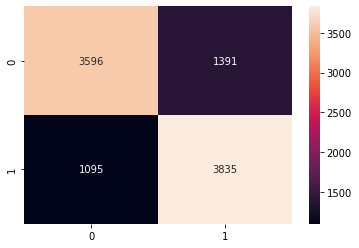

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

####Classification Report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.77      0.72      0.74      4987
           1       0.73      0.78      0.76      4930

    accuracy                           0.75      9917
   macro avg       0.75      0.75      0.75      9917
weighted avg       0.75      0.75      0.75      9917



###RNN + LSTM

In [ ]:
rnn_lstm_0 = Sequential()
rnn_lstm_0.add(Embedding(input_dim = trigrams_model.wv.vectors.shape[0], 
                           output_dim = trigrams_model.wv.vectors.shape[1], 
                           input_length = maxim,
                           weights = [trigrams_model.wv.vectors],
                           trainable=False))
rnn_lstm_0.add(SimpleRNN(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
rnn_lstm_0.add(LSTM(128, recurrent_dropout=0.1))
rnn_lstm_0.add(Dropout(0.25))
rnn_lstm_0.add(Dense(64))
rnn_lstm_0.add(Dropout(0.3))
rnn_lstm_0.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [ ]:
rnn_lstm_0.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
rnn_lstm_0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 117, 256)          16162304  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 117, 128)          49280     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [ ]:
checkpoint = ModelCheckpoint('/content/Mydrive/MyDrive/FinalYearProject/models/rnn_lstm_0.h5', 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='auto', 
                             period=1)

2022-05-05 09:16:57,868 : WARNING : `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of batches seen.


In [ ]:
rnn_lstm_history_0 = rnn_lstm_0.fit(X_train_pad, 
                                 y_train,
                                 validation_split=0.05, 
                                 batch_size=64, 
                                 epochs=50,
                                 callbacks=[checkpoint])

Epoch 1/50
589/589 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.6689
Epoch 1: val_accuracy improved from -inf to 0.81552, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/rnn_lstm_0.h5
589/589 [==============================] - 304s 510ms/step - loss: 0.5888 - accuracy: 0.6689 - val_loss: 0.4080 - val_accuracy: 0.8155
Epoch 2/50
589/589 [==============================] - ETA: 0s - loss: 0.3778 - accuracy: 0.8371
Epoch 2: val_accuracy improved from 0.81552 to 0.84778, saving model to /content/Mydrive/MyDrive/FinalYearProject/models/rnn_lstm_0.h5
589/589 [==============================] - 300s 510ms/step - loss: 0.3778 - accuracy: 0.8371 - val_loss: 0.3546 - val_accuracy: 0.8478
Epoch 3/50
589/589 [==============================] - ETA: 0s - loss: 0.3456 - accuracy: 0.8525
Epoch 3: val_accuracy did not improve from 0.84778
589/589 [==============================] - 298s 507ms/step - loss: 0.3456 - accuracy: 0.8525 - val_loss: 0.3502 - val_accura

In [ ]:
del rnn_lstm_0
gc.collect()

8336

In [ ]:
rnn_lstm_0 = load_model('/content/Mydrive/MyDrive/FinalYearProject/models/rnn_lstm_0.h5')

####Metrics

In [ ]:
y_pred = rnn_lstm_0.predict(X_test_pad)

In [ ]:
y_pred

array([[0.7362189],
       [0.9977864],
       [0.1907329],
       ...,
       [0.6731052],
       [0.9924378],
       [0.9547529]], dtype=float32)

In [ ]:
pred  = []
for p in y_pred:
  if p<0.5:
    pred.append(0)
  else:
    pred.append(1)
y_pred = np.array(pred)

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.8720379146919431

####Confusion Matrix

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)  
print(cf_matrix)

[[4375  612]
 [ 657 4273]]


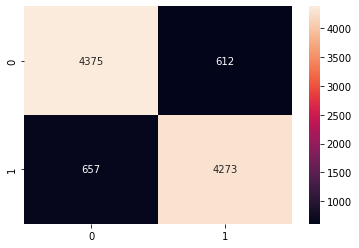

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='g')

####Classification Report

In [ ]:
report = classification_report(y_test, y_pred)
print('Report: \n',report)

Report: 
               precision    recall  f1-score   support

           0       0.87      0.88      0.87      4987
           1       0.87      0.87      0.87      4930

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917

